In [1]:
import math
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
#f_path = "E:/12月论文项目/data/time-series-dataset/dataset/exchange_rate/exchange_rate.csv"
f_path = "/root/iTransformer/dataset/exchange_rate/exchange_rate.csv"
df = pd.read_csv(f_path)

df.iloc[:,1:]
df['date']
print(df.iloc[:2000, 1].dtype)  # 检查数据类型
print(df.iloc[:2000, 1].isna().sum())  # 检查是否有缺失值
df


float64
0


,date,0,1,2,3,4,5,6,OT
0,1990/1/1 0:00,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.525486,0.593000
1,1990/1/2 0:00,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.523972,0.594000
2,1990/1/3 0:00,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.526316,0.597300
3,1990/1/4 0:00,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.523834,0.597000
4,1990/1/5 0:00,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.527426,0.598500
...,...,...,...,...,...,...,...,...,...
7583,2010/10/6 0:00,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.688565,0.690846
7584,2010/10/7 0:00,0.721839,1.223459,0.741155,0.977297,0.143763,0.008595,0.690288,0.695701
7585,2010/10/8 0:00,0.723197,1.234111,0.745184,0.984446,0.143997,0.008562,0.691419,0.695943
7586,2010/10/9 0:00,0.720825,1.233905,0.744131,0.980344,0.143993,0.008555,0.690942,0.692689


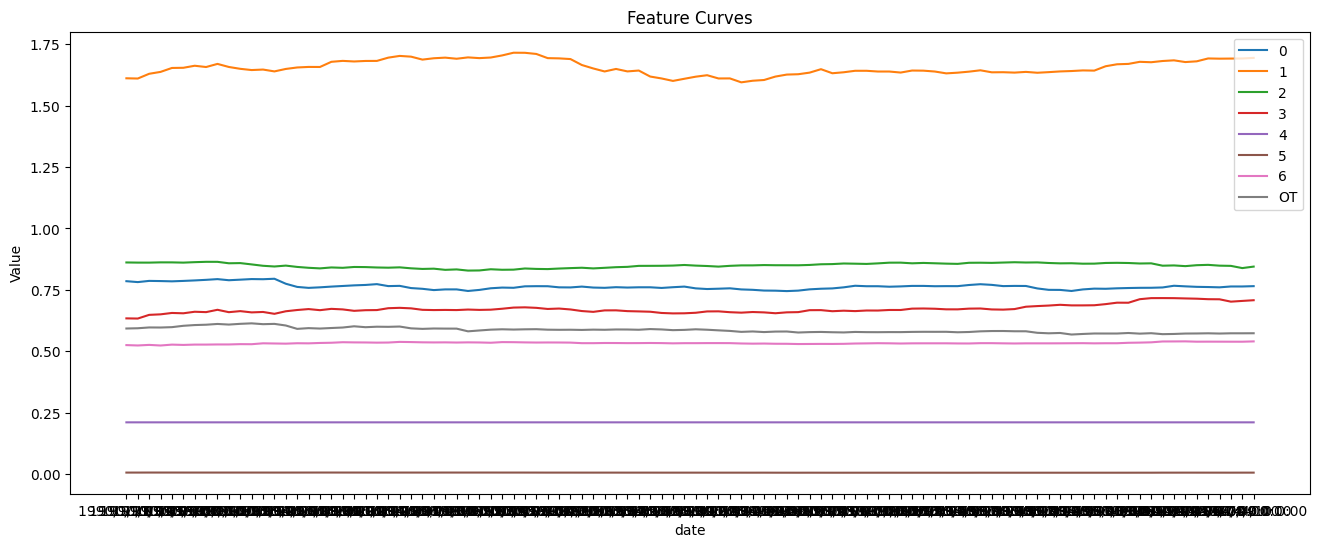

In [5]:
plt.figure(figsize=(16,6))
for c in df.columns[1:]:
    plt.plot(df['date'].iloc[:100], df[c].iloc[:100], label=c)
    
plt.title("Feature Curves")
plt.legend()
plt.xlabel("date")
plt.ylabel("Value")

plt.show()

In [6]:
df = df.iloc[:,1:].values

def make_data(dataframe, lookback, horizon):
    X, y = [], []
    for i in range(len(dataframe) - lookback - horizon +1):
        X.append(dataframe[i:i+lookback, :])
        y.append(dataframe[i+lookback:i+lookback+horizon, -1])
    return X, y

lookback = 96
horizon = 10
# use all features of last 96 to predict next 10 OT value
X, y = make_data(df, lookback, horizon)

In [47]:
X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
y = y.unsqueeze(2)
print(X.shape, y.shape)

torch.Size([7483, 96, 8]) torch.Size([7483, 10, 1, 1])


/tmp/ipykernel_1632/1264927697.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [48]:
src_dim = X.shape[-1]
tgt_dim = y.shape[-1]
tgt_dim

1

In [49]:
train_size = int(len(X)*0.7)
#test_size = int(len(X)*0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)
y_train.shape

torch.Size([5238, 10, 1, 1])

In [50]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 创建 Dataset 实例
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

# 创建 DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [51]:
next(iter(train_loader))[0].shape

torch.Size([16, 96, 8])

### Simple Transformer Encoder Model                
reference to https://www.wmathor.com/index.php/archives/1455/, Author: wmathor           
Module shematic:        
计算self-atten score      
multi-head attention module     
enclayer      
enc  (以上依次嵌套，只是此处enc只用了1层enclayer)      
FFN     
5个mudules

In [52]:
# hyper-param
d_model = 512  # Embedding Size
d_ff = 2048 # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 1  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention

In [53]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size, n_heads, len_q, len_k]
        #scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is True.
        
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V) # [batch_size, n_heads, len_q, d_v]
        return context, attn

In [66]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False).cuda()
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False).cuda()
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False).cuda()
        self.fc = nn.Linear(n_heads * d_v, d_model, bias=False)      #d_k不一定非要等于d_v，所以需要把V变成d_model
        
    def forward(self, input_Q, input_K, input_V):
        '''
        input_Q: [batch_size, len_q, d_model]
        input_K: [batch_size, len_k, d_model]
        input_V: [batch_size, len_v(=len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
        residual, batch_size = input_Q, input_Q.size(0)
        # (B, S, D) -proj-> (B, S, D_new) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # Q: [batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # V: [batch_size, n_heads, len_v(=len_k), d_v]

        #attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size, n_heads, seq_len, seq_len]

        # context: [batch_size, n_heads, len_q, d_v], attn: [batch_size, n_heads, len_q, len_k]
        context, attn = ScaledDotProductAttention()(Q, K, V)
        context = context.transpose(1, 2).reshape(batch_size, -1, n_heads * d_v) # context: [batch_size, len_q, n_heads * d_v]
        output = self.fc(context) # [batch_size, len_q, d_model]
        ###print(output.shape, residual.shape)
        return nn.LayerNorm(d_model).cuda()(output + residual), attn

In [67]:
class FeedForwardNet(nn.Module):
    def __init__(self):
        super(FeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=False)
        )
    def forward(self, inputs):
        '''
        inputs: [batch_size, seq_len, d_model]
        '''
        residual = inputs
        output = self.fc(inputs)
        return nn.LayerNorm(d_model).cuda()(output + residual) # [batch_size, seq_len, d_model]

In [68]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = FeedForwardNet()

    def forward(self, enc_inputs):
        '''
        enc_inputs: [batch_size, src_len, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        '''
        # enc_outputs: [batch_size, src_len, d_model], attn: [batch_size, n_heads, src_len, src_len]
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
        return enc_outputs, attn

In [69]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Linear(src_dim, d_model)    
        '''
        重点改动这里 不用nn Embedding，用Linear，因为要把([16, 96, 8])转成([16, 96, 512])
        用Embedding就变成了([16, 96, 8，512])会出现唯独不匹配报错，
        因此X，y类型是float tensor 不能是LongTensor
        '''
        
        #self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        self.projection = nn.Linear(d_model,1).cuda()
        self.forecast_horizon = horizon

    def forward(self, enc_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        '''
        enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]
        ###print("encoder:",enc_inputs.shape, enc_outputs.shape)
        #enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1).cuda() # [batch_size, src_len, d_model]
        #enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs) # [batch_size, src_len, src_len]
        enc_self_attns = []           #没用
        for layer in self.layers:
            # enc_outputs: [batch_size, src_len, d_model], enc_self_attn: [batch_size, n_heads, src_len, src_len]
            enc_outputs, enc_self_attn = layer(enc_outputs)
            enc_self_attns.append(enc_self_attn)
        output = enc_outputs[:, -self.forecast_horizon:, :]
        output = self.projection(output)
            # output: [batch_size, src_len, 1]
        return output, enc_self_attns

In [70]:
model = Encoder().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [79]:
for epoch in range(10):
    for x_loader, y_loader in train_loader:
      '''
      enc_inputs: [batch_size, src_len]
      dec_inputs: [batch_size, tgt_len]
      dec_outputs: [batch_size, tgt_len]
      '''
      x_loader, y_loader = x_loader.cuda(), y_loader.cuda()
      # outputs: [batch_size * tgt_len, tgt_vocab_size]
      outputs, _ = model(x_loader)
      #loss = criterion(outputs, dec_outputs.view(-1))
      loss = criterion(outputs, y_loader.view(-1))
      #print(outputs.shape,y_loader.shape)
      #print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))

Epoch: 0001 loss = 0.000000
Epoch: 0002 loss = 0.000000
Epoch: 0003 loss = 0.000000
Epoch: 0004 loss = 0.000000
Epoch: 0005 loss = 0.000000
Epoch: 0006 loss = 0.000003
Epoch: 0007 loss = 0.000002
Epoch: 0008 loss = 0.000000
Epoch: 0009 loss = 0.000001
Epoch: 0010 loss = 0.000000


仅仅是跑通没bug,可能会有不少问题，还没有在testset中验证效果，并且这只是最简单的一个实现方法